# Lab 1 - Interpreted Languages and Grammars

## Imports and useful functions

In [3]:
from numpy.random import choice
import numpy as np
import matplotlib.pyplot as plt
import re
from ColabTurtlePlus import Turtle as t
import ColabTurtlePlus as ctp
import IPython

import cairosvg
import io
from PIL import Image, ImageFilter
from scipy.signal import sawtooth
from pprint import pprint
import seaborn as sns
import IPython

Put clearscreen() as the first line in a cell (after the import command) to re-run turtle commands in the cell


In [4]:
from symbolic_utilities import normalize, apply_rule, complete

In [5]:
from symbolic_utilities import get_svg, blur_img, svg_to_img

## Formal Grammars 

In the lecture, we have covered what grammars are and how they help us define a space of possible programs for our program induction system. In this lab, we will see how to define and interpret them in python. 

One simple and intuitive way of implementing a grammar in python is as a dictionary:
- The keys are the left hand side rules 
- The values are lists containing the possible strings that can be substituted by the key.

> __NOTE__: To see why we need to use lists as values rather than using a different key for each rule, try to repeat the same key more than once. What happens?

For instance, let's write the grammar with the following rules:
$$
S \rightarrow aS | bS | \epsilon
$$

In [39]:
grammar = {
    'S': [
        'aS', 
        'bS', 
        'aSa',
        'bSb',
        ''
    ]
}

One thing we can do with this way of defining grammars is writing a function that randomly applies rule until we get to a string consisting only of terminals:

In [42]:
# always start with the starting symbol
current_sentence = 'S'
# while there is a non-terminal in the sentence
while 'S' in current_sentence:
    # substitute the first occurrence of S
    # with a randomly chosen substitution rule
    current_sentence = current_sentence.replace(
        'S', 
        choice((grammar['S'])),
        # NOTE: in this particular case there will always
        # only be one S, but this is not true for 
        # all grammars!
        1
    )
print('String: ', current_sentence)

String:  bbaaabbaaaaaaaababaaaabaabb


As an exercise, write a function that takes a grammar, a set of terminals, and a set of nonterminals, and determines whether the grammar is context-free (Spend about 20 minutes on this - if you see that you can do it, leave it!):

In [ ]:
# Your function here




Now we define a _probabilistic_ context-free grammar by adding the (unnormalized) probability of applying the rule rather than the other rules with the same left-hand side.

In [ ]:
#### your class definition here!



Define a function that generates a random production in the language by iteratively applying the rules according to the defined probabilities. The following code should run (but possibly give a different answer on different runs):

```python
generate(grammar)
```

printing e.g.,
```python
aabbaa
```

In [ ]:
#### Test generate here!



What happens when we increase...

- the probability of the rule $S \rightarrow aSa$?
- the probability of the rule $S \rightarrow bSb$?
- the probability of the rule $S \rightarrow \epsilon$?

## Case study 1: Basic arithmetic

Let's put all of these tools together into a couple case studies: a simple grammar for arithmetic, a grammar of shapes, and a grammar of sounds. 

Before we get onto interpreting sentences from the grammar, we need a grammar to produce sentences with. For simplicity, we will encode the language as a dictionary. The keys are the left-hand side of substitution rules, the values a list of possible right-hand sides. 

> __NOTE__ We will put non-terminals between angle brackets, e.g. `'<S>'` to simplify parsing the strings.

Let's construct a very simple grammar:

In [5]:
CFG_arithmetic = {
    '<S>': ['plusOne(<S>)', 'one']
}

Let's produce a random string:

In [10]:
complete('<S>', CFG_arithmetic)

'plusOne(plusOne(plusOne(plusOne(one))))'

Note that even though we have a sentence now and we have an _intuitive_ sense of what it could mean, we still need a way of implementing the interpretation in python. So let's do that!

Let's get onto interpretation. We will use $\lambda$ expressions to encode the meaning of our operators. Thankfully this is made quite easy by Python's lambda syntax, which we have seen a couple of weeks ago. We want to interpret the very simple arithmetic language defined above. We assume a type system with:
- One primitive type $n$, the type of integers.
- Function types defined inductively: $<\alpha, \beta>$ is the set of functions from things of type $\alpha$ to things of type $\beta$.

We can give meanings to all the terminals in our language. We do this in a dictionary: the keys are the terminals of our grammar and the values are the meanings, written as $\lambda$ expressions:

In [11]:
meanings = {
    # type n
    'one': 1,
    # type <n,n>
    'plusOne': lambda x: x+1
}

Our primitives can be applied to each other in a way consistent with their types:

In [12]:
# n to n
meanings['plusOne'](
    # n to n
    meanings['plusOne'](
        # n
        meanings['one']
    )
)

3

If the primitives in the language are defined, we can also write a string in the language as a python string, e.g., `'plusOne(one)'`. This is useful when e.g. building random strings from the language. However, we need a way to go from the string to the _interpreted_ string. For this, we exploit python's own interpreter via the keyword `eval`. Python's `eval` function plays the role of the interpretation function which we discussed in class, but it allows us to not take care of parsing brackets (going from a string to the underlying parse tree to interpret).

> __NOTE__ It is generally not recommended to use Python's `eval`. We will use it here only to evaluate sentences in our hand-made grammars, but never let it evaluate something you don't understand! We can pass `meanings` as the second argument of `eval` to tell it which symbols to interpret.

Let's see a simple example:

In [13]:
eval('plusOne(plusOne(one))', meanings)

3

Now we have a way of generating random strings from our gramnmar, as well as interpreting them. Therefore, we can study what happens when we produce a bunch of random strings. For instance, we can ask: what's the distribution of numbers produced by our PCFG?

In [17]:
# plot distribution of numbers obtained with this grammar
numbers = [
    eval(complete('<S>', CFG_arithmetic), meanings) 
    for _ in range(10000)
]

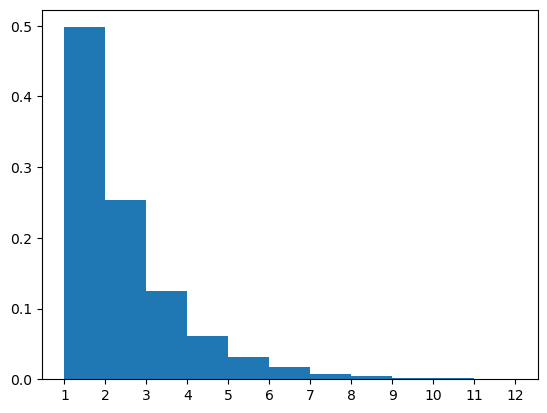

In [18]:
plt.hist(numbers, density=True, bins=np.arange(1,13))
plt.xticks(np.arange(1, 13))
plt.show()

Turns out the probability of each number $n$ is $2^{-n}$. Can you tell why?

In practice, we'll mostly work with _probabilistic_ context free grammars. The idea here is that for each nonterminal we specify the probability of each possible substitution. A natural way of doing this here is, instead of having simply a list of possible substitutions as the value of the grammar dictionary, we have a list of tuples. The first element of each tuple is the (unnormalized) probability of that substitution rule, the second element is the actual right-hand side. 

Applying this to our simple arithmetic grammar above:

In [19]:
CFG_arithmetic = {
    '<S>': [
        (1, 'plusOne(<S>)'), 
        (1, 'one')
    ]
}

Our function `complete` still works, but now applies substitution rules with the given probabilities:

In [28]:
complete('<S>', CFG_arithmetic)

'plusOne(plusOne(one))'

Our simple arithmetical grammar is cool and all, but extremely small. Let's enrich it slightly:

In [29]:
CFG_arithmetic = {
    '<S>': [
        (1, 'plusOne(<S>)'), 
        (1, 'one'),
        # NEW!
        (0.3, 'plus(<S>)(<S>)'),
        (0.3, 'minus(<S>)(<S>)')
    ]
}

In [30]:
CFG_arithmetic

{'<S>': [(1, 'plusOne(<S>)'),
  (1, 'one'),
  (0.3, 'plus(<S>)(<S>)'),
  (0.3, 'minus(<S>)(<S>)')]}

We also need to add the meaning of the new terminals:

In [31]:
# type <n,<n,n>>
meanings['plus'] = lambda x: lambda y: x + y
# type <n,<n,n>>
meanings['minus'] = lambda x: lambda y: x - y

Make sure that we can interpret the strings produces by the expanded grammar:

In [32]:
eval('plus(plusOne(plusOne(one)))(plusOne(one))', meanings)

5

Let's produce a bunch of sentences in the new grammar and see what distribution their interpretation takes:

In [33]:
# plot distribution of numbers obtained with this grammar
numbers = [
    eval(complete('<S>', CFG_arithmetic), meanings) 
    for _ in range(10000)
]

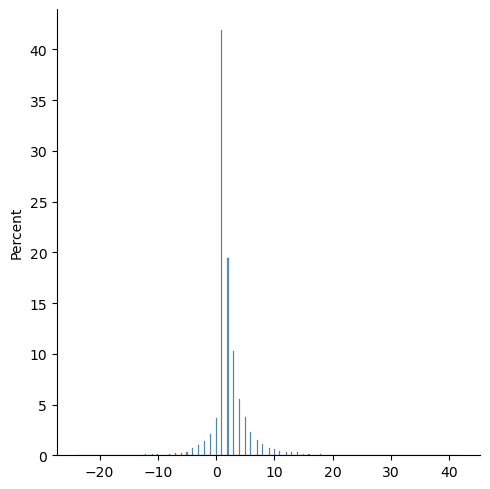

In [39]:
sns.displot(
    numbers,
    stat='percent'
)

That was a very simple example, but of course there's much more we can do with grammars!

## Case study 2: Shapes

Numbers are cool, but we can do more interesting stuff too. For instance, shapes! 

You can think of a shape as the result of a sequence of movements of a pen, e.g., 'move forward', 'move backward', etc. Based on these movements and ways to combine them, we can define a grammar that produces series of instructions that define shapes:

\begin{align}
\langle\text{START}\rangle 
&\rightarrow 
\text{chain}(\langle\text{DRAWING}\rangle) \\
\langle\text{DRAWING}\rangle 
&\rightarrow 
\langle\text{MOVEMENT}\rangle,\langle\text{DRAWING}\rangle \\
&\rightarrow 
\epsilon
\\
\langle\text{MOVEMENT}\rangle 
&\rightarrow  
\text{forward}(\langle\text{DISTANCE}\rangle) \\
&\rightarrow 
\text{backward}(\langle\text{DISTANCE}\rangle) \\
&\rightarrow 
\text{right}(\langle\text{ANGLE}\rangle) \\
&\rightarrow 
\text{left}(\langle\text{ANGLE}\rangle) \\
&\rightarrow 
\text{circle}(\langle\text{DISTANCE}\rangle, \langle\text{ANGLE}\rangle) \\
&\rightarrow 
\text{goto}(0,0)
\\
\langle\text{DISTANCE}\rangle 
&\rightarrow 50 \mid 100 \mid 120
\\
\langle\text{ANGLE}\rangle 
&\rightarrow 30 \mid 60 \mid 90 \mid 170
\end{align}

In [2]:
grammar = {
    '<start>': [(1,'chain(<drawing>)')],
    # always start with a drawing
    '<drawing>': [
        # a drawing can include a movement 
        # follows by a drawing (recursive!)
        (8, '<movement>,<drawing>'),
        # at some point the drawing ends
        (1, ''),
    ],
    # a movement is basically a single instruction
    # so a drawing consists of a series of movements
    # Movements have two types of parameters,
    # namely: angles and distances
    '<movement>': [
        (1, 'forward_(<distance>)'),
        (1, 'backward_(<distance>)'),
        (1, 'right_(<angle>)'),
        (1, 'left_(<angle>)'),
        (1, 'circle_(<distance>,<angle>)'),
        (1, 'goto_(0,0)')
    ],
    # hand-specify some distances
    '<distance>': [
        (1, '10'),
        (1, '20'),
        (1, '50'),
    ],
    # hand-specify some angles
    '<angle>': [
        (1, '30'),
        (1, '60'),
        (1, '90'),
        (1, '170')
    ]
}

You can check what happens when you generate a random sentence from the grammar:

In [8]:
instructions = complete('<start>', grammar)
print(instructions)

chain(left_(60),goto_(0,0),)


This is cool and all, but it is just a sequence of symbols: we want to _interpret_ this to get a shape. We will do this in two steps:
1. Figure out how to encode shapes in python
2. Define an interpretation function that assigns a shape to each generation from our grammar.


For step 1, instead of defining a system of shape encoding ourselves, we can rely on an already existing library. We will use Python's 'turtle' library. The idea is very simple: Imagine a little turtle that moves around the screen according to certain instructions, and as it moves around it traces a line. Instructions are things like 'move forward', 'go around some of a circle', etc. Each sentence in our grammar gets interpreted by the turtle library into a shape.

Here's an example to show you how Turtle works:

In [27]:
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(13)
t.forward(100); t.circle(50,90); t.forward(100)

In [16]:
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(13)
t.forward(10); t.circle(20,60); t.right(90); t.forward(100); t.goto(0,0)

For the second step, just like we saw in the lecture, we assign an interpretation to each terminal symbol in our grammar. We associate each terminal with an expression using the Turtle library. Essentially, we are treating the Turtle library as a metalanguage that we can do computations with.

In [10]:
forward_ = lambda x: lambda : t.forward(x)
backward_ = lambda x: lambda : t.backward(x)
right_ = lambda x: lambda : t.right(x)
left_ = lambda x: lambda : t.left(x)
circle_ = lambda x, y: lambda : t.circle(x,y)
goto_ = lambda x, y: lambda : t.goto(x,y)

def chain(*args, speed=0):
    # args is a list of functions
    t.initializeTurtle(window=(100,100))
    t.hideturtle()
    t.color('black')
    t.speed(speed)
    for f in args:
        f()
    screen = t.Screen()
    return get_svg(screen)

So far so good, but we also want to define interpretation for full sentences rather than just terminals. To do this, we just rely on Python's own interpreter. If you go back to the grammar's definition you can see that it was constructed to be in line with python's notation for function calls. Therefore, we can just use `eval` to evaluate the grammar's generations into Turtle drawings:

Drawing:
 <svg width="100" height="100" viewBox="0 0 100 100" xmlns="http://www.w3.org/2000/svg">
<rect width="100%" height="100%" style="fill:white;stroke:;stroke-width:1" />
<line x1="50.0" y1="50.0" x2="50.0" y2="50.0" stroke-linecap="round" style="stroke:black;stroke-width:1" />
<line x1="50.0" y1="50.0" x2="50.0" y2="70.0" stroke-linecap="round" style="stroke:black;stroke-width:1" />
<line x1="50.0" y1="70.0" x2="50.0" y2="20.0" stroke-linecap="round" style="stroke:black;stroke-width:1" />
<line x1="50.0" y1="20.0" x2="50.0" y2="50.0" stroke-linecap="round" style="stroke:black;stroke-width:1" />
<path d="M 50.0 50.0 A 20 20 0 0 0 30.0 30.0" stroke-linecap="round" 
            fill="transparent" fill-opacity="0" style="stroke:black;stroke-width:1"/>
<line x1="30.0" y1="30.0" x2="50.0" y2="50.0" stroke-linecap="round" style="stroke:black;stroke-width:1" />
</svg>


[]

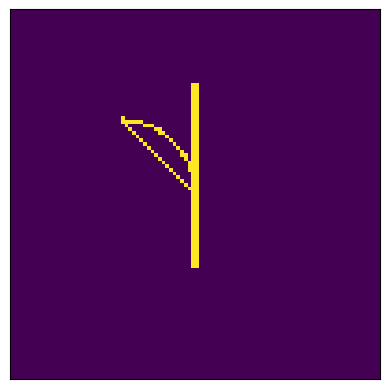

In [25]:
# a sample generation from the grammar
sample = "chain(goto_(0,0),left_(90),backward_(20),forward_(50),goto_(0,0),circle_(20,90),right_(30),left_(30),goto_(0,0),)"
# use python's own interpreter to interpret the string according to the meanings defined above
drawing = eval(sample)
# we get an svg object!
print("Drawing:\n", drawing)
# get can convert the svg to an image
img = svg_to_img(drawing)
# ...and plot the image
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])

We drew a wee branch!

Try to run this multiple times and note that sometimes the result is just empty or a straight line, and sometimes it is some interesting, complex shapes:

chain(backward_(10),forward_(20),circle_(20,30),forward_(20),goto_(0,0),circle_(50,90),forward_(10),circle_(20,90),circle_(20,60),right_(30),circle_(10,170),left_(170),left_(170),forward_(10),right_(60),right_(170),left_(90),circle_(20,170),circle_(20,60),left_(170),backward_(50),forward_(10),)
chain(goto_(0,0),right_(30),forward_(10),goto_(0,0),left_(30),backward_(50),)
chain(circle_(20,60),right_(90),right_(60),backward_(20),backward_(50),forward_(20),forward_(50),right_(60),)


[]

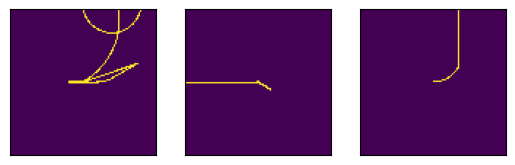

In [26]:
n_imgs = 3

imgs = []
for i in range(n_imgs):
    # define the 'central' part of the instructions
    instructions = complete('<start>', grammar)

    print(instructions)
    # add some needed scaffolding around the 
    # sentence produced by the grammar
    svg_representation = eval(instructions)
    imgs.append(
        svg_to_img(
            svg_representation,
        )
    )

fig, axes = plt.subplots(
    1,
    len(imgs), 
    sharey=True, 
    sharex=True
)

for ax, im in zip(axes, imgs):
    ax.imshow(im)

axes[0].set_xticks([])
axes[0].set_yticks([])

The point here is: each sentence in our grammar is a shape.

> Practical note: Sometimes we do not want to see the full animation, but rather just the final product. In that case, we can set speed at 0 and then call `done`, as follows:

```
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(0)
for i in range(20): {instructions}
t.done()
```

Ultimately, we want to use the interpreted grammar to _backengineer_ the expression that produced the image. Often, when dealing with real data, our observations are not perfect representations of the sentence, but rather some noisy version of it. Suppose for instance that these shapes are e.g., drawing on an old touch screen. In that case, we might have observational noise: some pixels might randomly change from 0 to 1 or viceversa. We can simulate this by adding noise to the grammar's generation, as follows:

chain(backward_(10),backward_(50),circle_(10,90),goto_(0,0),left_(60),backward_(20),circle_(10,170),circle_(50,60),) 

chain() 

chain(backward_(20),circle_(20,170),goto_(0,0),) 



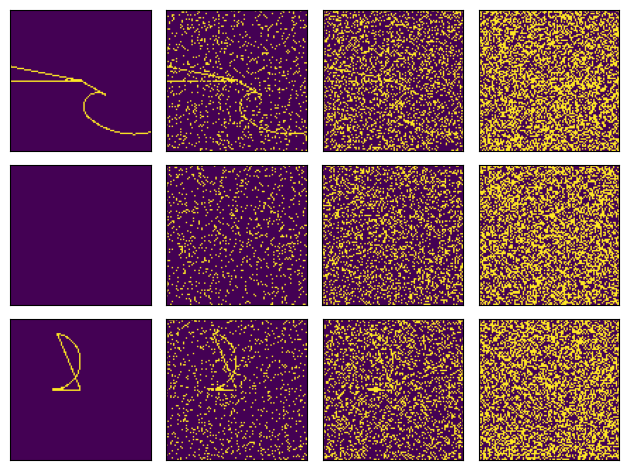

In [56]:
n_shapes=3
degrees_noise = [0, 0.2, 0.5, 0.9]

images = []
for i in range(n_shapes):
    instructions1 = complete('<start>', grammar)
    print(instructions1, "\n")
    svg_representation = eval(instructions1) 
    for d in degrees_noise:
        img = svg_to_img(
            svg_representation,
            d
        )
        images.append(img)

fig, axes = plt.subplots(
    n_shapes,
    len(degrees_noise), 
    sharex=True, 
    sharey=True
)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for ax, im in zip(axes.flatten(), images):
    ax.imshow(im)

fig.tight_layout()

I hope you share the intuition that the higher the noise, the harder it is going to be to do program induction of the underlying shape!

Some questions for reflection:

- How would you change the grammar to make the shapes more round?
- How about making them more "spiky"?
- Can you think of other kinds of noise?
- How would they affect the difficulty of reconstructing the underlying shape?

## Case study 3: Sounds

Sounds provide another interesting domain for program synthesis. What could a simple grammar for sounds look like? Let's define a very simple grammar of music which can nonetheless encode many possible sounds:

\begin{align}
\langle\text{TUNE}\rangle 
&\rightarrow 
\langle\text{NOTE}\rangle 
\\
&\rightarrow 
\text{successive}(\langle\text{TUNE}\rangle,\langle\text{TUNE}\rangle) 
\\
&\rightarrow 
\text{melt}(\langle\text{TUNE}\rangle,\langle\text{TUNE}\rangle) 
\\
\langle\text{NOTE}\rangle 
&\rightarrow 
\text{defineNote}(\langle\text{FREQ}\rangle,\langle\text{TIME}\rangle)
\\
\langle\text{TIME}\rangle 
&\rightarrow 
0.1 \mid 0.2 \mid 0.3
\\
\langle\text{FREQ}\rangle 
&\rightarrow 
\text{A} \mid \text{Bb} \mid \text{B} \mid \text{C} \mid \text{Db} \mid \text{D} \mid \text{Eb} \mid \text{E} \mid \text{F} \mid \text{Gb} \mid \text{G} \mid \text{Ab}
\end{align}

Define each note in an octave, so we can call them by name as described in the grammar:

In [30]:
freqs = {
    'A': 220,
    # 'Bb': 233.08,
    # 'B': 246.94,
    'C': 261.63,
    # 'Db': 277.18,
    'D': 293.66,
    # 'Eb': 311.13,
    'E': 329.63,
    # 'F': 349.23,
    # 'Gb': 369.99,
    'G': 392.00,
    # 'Ab': 415.30,
}

And let's define some ways sounds can compose sequentially or concurrently:

In [31]:
soundGrammar = {
    '<tune>': [
        (3, '<note>'),
        (1, 'successive(<tune>, <tune>)'),
        (1, 'melt(<tune>, <tune>)')
    ],
    '<note>': [
        (1, "defineNote('<freq>', <time>)")
    ],
    '<freq>': [(1,x) for x in freqs.keys()],
    '<time>': [
        (1, '0.3'), 
        (1, '0.6'), 
        (1, '1.'),
    ]
}

In [32]:
pprint(soundGrammar)

{'<freq>': [(1, 'A'), (1, 'C'), (1, 'D'), (1, 'E'), (1, 'G')],
 '<note>': [(1, "defineNote('<freq>', <time>)")],
 '<time>': [(1, '0.3'), (1, '0.6'), (1, '1.')],
 '<tune>': [(3, '<note>'),
            (1, 'successive(<tune>, <tune>)'),
            (1, 'melt(<tune>, <tune>)')]}


Now that we have a grammar, we can define the semantics.

In [33]:
# define rate (don't worry about this!)
fs = 44100

We are going to need a way of defining notes given a frequency:

In [34]:
def defineNote(frequency, seconds, fs=44100, harmonic_strength=0.1):

    if isinstance(frequency, str):
        frequency = freqs[frequency]
    # jitter frequency slightly to reduce strident interference
    # frequency = np.random.rand()*3 + frequency
    
    # seconds*sample_rate steps 
    # between 0 and seconds
    t = np.linspace(0, seconds, int(seconds * fs), False)

    # Harmonics
    harmonics = np.zeros_like(t)
    # Adding the first 10 harmonics
    for i in range(2, 11):  
        harmonics += (
            np.sin(frequency * i * t * 2 * np.pi)
            # sawtooth(2 * np.pi * i * frequency * t, 0.5)
            * np.exp(-i * harmonic_strength)
        )

    # Fundamental frequency
    note = np.sin(frequency * t * 2 * np.pi) + harmonics
    # note = sawtooth(2 * np.pi * frequency * t, 0.5)

    return note

We'll also need a way of melting two notes, i.e. playing them together:

In [35]:
def melt(note1, note2):
    # if they are of different lengths,
    # pad the shorter one with 0s
    diff = len(note1) - len(note2)
    if diff < 0:
        note1 = np.concatenate((
            note1,
            np.zeros(-diff, dtype=int)
        ))
    elif diff > 0:
        note2 = np.concatenate((
            note2,
            np.zeros(diff, dtype=int)
        ))

    combined = note1+note2
    audio = combined * (2**15 - 1) / np.max(np.abs(combined))
    audio = audio.astype(np.int16)
    
    return audio

And a way of appending one note to another one:

In [36]:
def successive(note1, note2):
    return np.concatenate((note1, note2))

And finally collect all the primitive meanings we defined in a single dictionary, so that we can use it with `interpret` to get the meaning of each sentence produced by the grammar:

In [37]:
interpret = {
    **freqs,
    'defineNote': defineNote,
    'melt': melt,
    'successive': successive 
}

We also want to convert our meanings, encoded as frequencies, into sounds we can actually hear. So we can make "music" (of the worst imaginable kind). Let's head these wonderful "tunes":

In [12]:
simple_A = defineNote(220, 1, harmonic_strength=0.1)

IPython.display.Audio(
    # put note or notes here!
    simple_A, 
    rate=fs, 
    autoplay=True
)

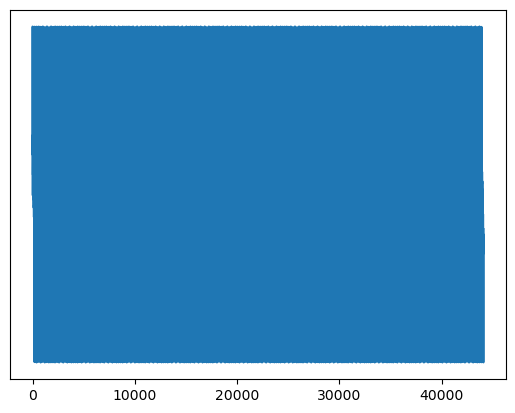

In [2425]:
plt.plot(simple_A)
plt.yticks([])
plt.savefig('imgs/simple_A.png')

Test the function:

In [2377]:
melted = melt(
    defineNote(freqs['A'], 1),
    defineNote(freqs['D'], 2)
)

IPython.display.Audio(
    melted, 
    rate=fs, 
    autoplay=True
)

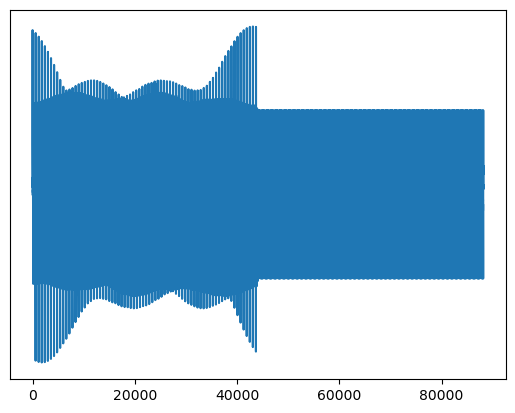

In [2426]:
plt.plot(melted)
plt.yticks([])
plt.savefig('imgs/example_melt.png')

Run this until you get something long that looks interesting! As in the geometric example above, some productions are very simple while others are very messy and complicated.

In [16]:
tune = complete('<tune>', soundGrammar)
pprint(tune)

("successive(defineNote('A', 1.), successive(defineNote('E', 0.3), "
 "successive(defineNote('A', 0.3), melt(defineNote('D', 0.6), defineNote('E', "
 '1.)))))')


In [17]:
IPython.display.Audio(
    # put note or notes here!
    eval(tune, interpret), 
    rate=fs, 
    autoplay=True
)

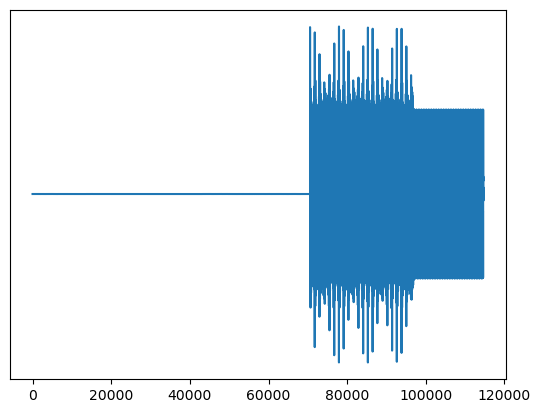

In [18]:
plt.plot(eval(tune))
plt.yticks([])
plt.savefig('imgs/complex_example.png')

This is not going to sound very good, possibly because the grammar is not encoding any of the interesting structure we like in music. 

Just like we did above, we can create a noisy observation:

In [2430]:
tune = complete('<tune>', soundGrammar)
pprint(tune)
sound = eval(tune, interpret)
sigma = np.max(sound)/3
print(sigma)
noisy_sound = sound + np.random.normal(scale=sigma, size=sound.shape)

("melt(defineNote('A', 0.3), successive(melt(defineNote('G', 0.3), "
 "melt(successive(defineNote('A', 0.6), defineNote('A', 1.)), "
 "melt(successive(melt(defineNote('D', 0.6), successive(defineNote('C', 0.6), "
 "melt(successive(defineNote('C', 0.3), defineNote('D', 0.3)), defineNote('E', "
 "1.)))), defineNote('D', 0.6)), successive(defineNote('E', 0.6), "
 "defineNote('C', 1.))))), melt(successive(defineNote('E', 0.3), "
 "defineNote('C', 1.)), melt(defineNote('C', 1.), melt(defineNote('A', 0.6), "
 "defineNote('E', 0.3))))))")
10922.333333333334


In [2484]:
print(tune)

successive(defineNote('G', 0.6), successive(defineNote('D', 0.6), successive(successive(successive(successive(defineNote('G', 0.3), melt(melt(defineNote('A', 0.3), successive(defineNote('C', 1.), defineNote('D', 0.3))), defineNote('G', 0.6))), defineNote('E', 0.6)), defineNote('E', 0.6)), successive(melt(melt(defineNote('E', 0.6), successive(defineNote('C', 0.3), defineNote('D', 1.))), defineNote('G', 0.3)), defineNote('G', 0.3)))))


Now this sounds literally noisy:

In [2431]:
IPython.display.Audio(
    # put note or notes here!
    sound, 
    rate=fs, 
    autoplay=True
)

In [2432]:
IPython.display.Audio(
    # put note or notes here!
    noisy_sound, 
    rate=fs, 
    autoplay=True
)

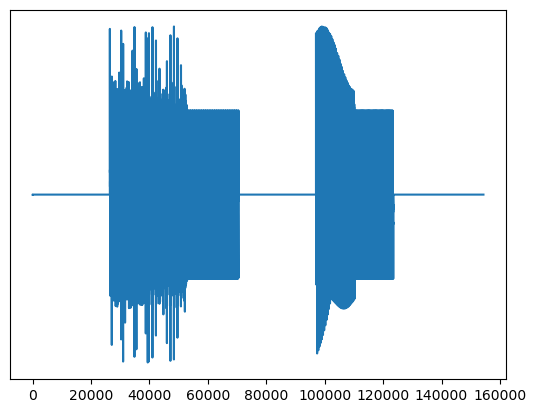

In [2435]:
plt.plot(sound)
plt.yticks([])
plt.savefig('imgs/clean_example.png')

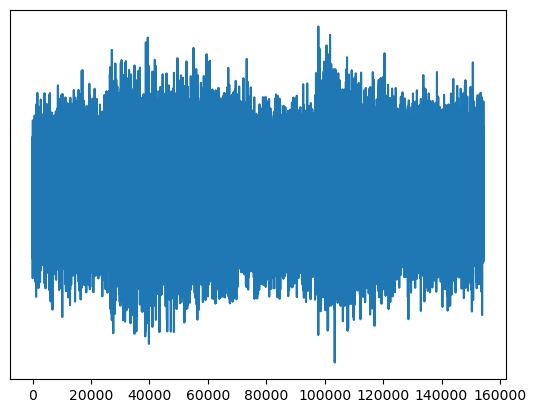

In [2436]:
plt.plot(noisy_sound)
plt.yticks([])
plt.savefig('imgs/noisy_example.png')

Now we can generate a few random sounds from the grammar and add noise, to compare:

In [38]:
tune0 = complete('<tune>', soundGrammar)
tune1 = complete('<tune>', soundGrammar)
tune2 = complete('<tune>', soundGrammar)

print(tune0, '\n')
print(tune1, '\n')
print(tune2, '\n')

defineNote('E', 0.6) 

successive(defineNote('G', 1.), melt(defineNote('C', 1.), defineNote('C', 0.3))) 

defineNote('D', 0.6) 



In [ ]:
sound0 = eval(tune0, interpret)
sound1 = eval(tune1, interpret)
sound2 = eval(tune2, interpret)

sigma0 = np.max(sound0)/3
sigma1 = np.max(sound1)/3
sigma2 = np.max(sound2)/3

# make them all equally long
max_length = np.max([sound0.shape, sound1.shape, sound2.shape])

# diff from max length
sound0 = np.concatenate([
    sound0,
    np.zeros(np.abs(sound0.shape-max_length))
])

sound1 = np.concatenate([
    sound1,
    np.zeros(np.abs(sound1.shape-max_length))
])

sound2 = np.concatenate([
    sound2,
    np.zeros(np.abs(sound2.shape-max_length))
])

noisy_sound0 = sound0 + np.random.normal(scale=sigma0, size=sound0.shape)
noisy_sound1 = sound1 + np.random.normal(scale=sigma1, size=sound1.shape)
noisy_sound2 = sound2 + np.random.normal(scale=sigma2, size=sound2.shape)

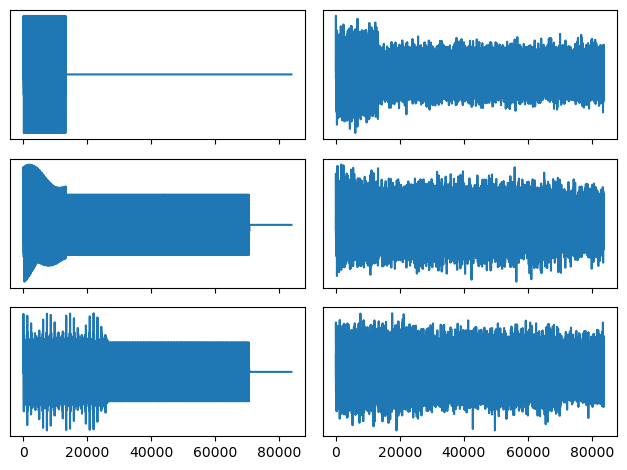

In [209]:
fig, axes = plt.subplots(3,2,sharex=True)
((ax1, ax2, ax3), (noise_ax1, noise_ax2, noise_ax3)) = axes.T
ax1.plot(sound0)
noise_ax1.plot(noisy_sound0)
ax2.plot(sound1)
noise_ax2.plot(noisy_sound1)
ax3.plot(sound2)
noise_ax3.plot(noisy_sound2)

for ax in axes.flatten():
    ax.set_yticks([])

fig.tight_layout()
fig.savefig('imgs/prior_lik_compare.png')

In [211]:
IPython.display.Audio(
    sound0, 
    rate=fs, 
    autoplay=True
)

In [212]:
IPython.display.Audio(
    noisy_sound0, 
    rate=fs, 
    autoplay=True
)

In [213]:
IPython.display.Audio(
    sound1, 
    rate=fs, 
    autoplay=True
)

In [214]:
IPython.display.Audio(
    noisy_sound1, 
    rate=fs, 
    autoplay=True
)

In [215]:
IPython.display.Audio(
    sound2, 
    rate=fs, 
    autoplay=True
)

In [216]:
IPython.display.Audio(
    noisy_sound2, 
    rate=fs, 
    autoplay=True
)

Some questions for reflection:

- How could we change the vibe to be more calm?
- How could we modify the grammar to make tunes less 'messy'?
- How could we encode more interesting structure?

In this notebook, we have seen how to define grammars and interpretation functions. This is the first step towards a program induction system; The second step will be to search the sentences generated by the grammar to find one that fits the observed data. That will be the topic of the next module.